In [233]:
import pandas as pd
import numpy as np

In [234]:
#importing from google collab drive
from google.colab import drive

drive.mount('/content/drive')

file_path = "/content/drive/My Drive/axbk/axbk_oneyear.csv"
dataframe=pd.read_csv(file_path)
dataframe.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,open,high,low,prevclose,close,vwap,volume,ntrades
0,18-Mar-25,1044.15,1054.25,1033.7,1034.15,1045.25,1042.91,7365940.0,144396.0
1,17-Mar-25,1011.10,1039.00,1011.1,1010.20,1034.15,1026.93,5938668.0,176948.0
2,13-Mar-25,1015.00,1016.00,1005.1,1011.20,1010.20,1010.80,4004140.0,93202.0
3,12-Mar-25,1025.20,1029.80,999.2,1025.65,1011.20,1009.41,7504702.0,258740.0
4,11-Mar-25,1030.40,1036.80,1021.1,1035.85,1025.65,1027.51,4771085.0,229713.0


In [235]:
#making date into datetype
dataframe['date'] = pd.to_datetime(dataframe['date'], format="%d-%b-%y")
# Handling missing values
dataframe.fillna(dataframe.mean(), inplace=True)
#printing shape of data
print("shape of data",dataframe.shape)
#printing the first few rows
dataframe.head()

shape of data (249, 9)


,date,open,high,low,prevclose,close,vwap,volume,ntrades
0,2025-03-18,1044.15,1054.25,1033.7,1034.15,1045.25,1042.91,7365940.0,144396.0
1,2025-03-17,1011.10,1039.00,1011.1,1010.20,1034.15,1026.93,5938668.0,176948.0
2,2025-03-13,1015.00,1016.00,1005.1,1011.20,1010.20,1010.80,4004140.0,93202.0
3,2025-03-12,1025.20,1029.80,999.2,1025.65,1011.20,1009.41,7504702.0,258740.0
4,2025-03-11,1030.40,1036.80,1021.1,1035.85,1025.65,1027.51,4771085.0,229713.0


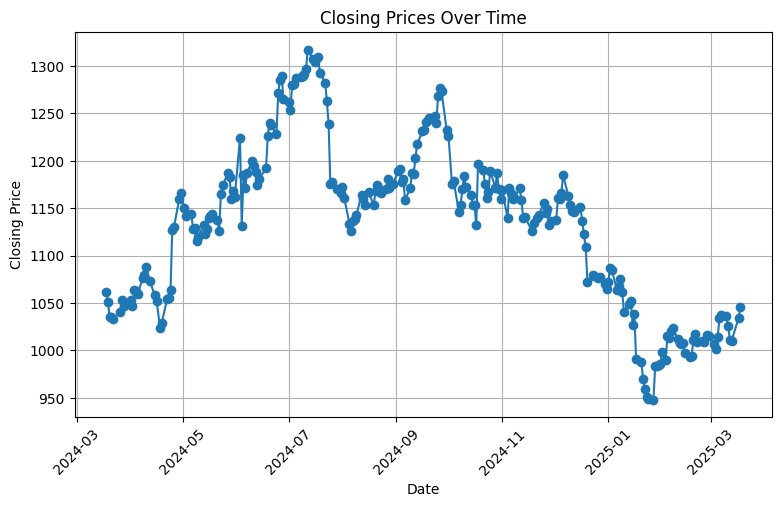

In [236]:
#plotting data
import matplotlib.pyplot as plt

dataframe.sort_values('date', inplace=True)  # Sort dates properly
dataframe.set_index('date', inplace=True)  # Set as index

# Plot closing prices
plt.figure(figsize=(9, 5))
plt.plot(dataframe.index, dataframe['close'], marker='o', linestyle='-')

# Formatting
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing Prices Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid()

# Show the plot
plt.show()

IMP takeaway - if a column is set as the index then any modification in the codebase, will give an error of the index column not being recognized. hence you have to run the entire codebase again

In [237]:
#import pandas as pd installed
#import matplotlib.pyplot as plt installed
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [238]:
#cleaning the close column if there is disparency in the csv file
#dataframe["Close"] = dataframe["Close"].replace(',', '', regex=True)
#dataframe["Close"] = pd.to_numeric(dataframe["Close"], errors='coerce')
#dataframe["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)
#dataframe.dropna(subset=["Close"], inplace=True)

While ARIMA models can deal with non-stationarity up to a point, they cannot effectively account for time-varying variance. In other words, for an ARIMA model to really work, the data has to be stationary.

Stationary doesnt mean redundant data - In time series analysis, stationarity means that the statistical properties of the series (like mean, variance, and autocorrelation) do not change over time.

It needs to have
*Constant Mean* – The average value does not change over time.
*Constant Variance* – The spread of the data remains the same.
*Constant Autocorrelation* – Relationships between past and present values are stable.

Looking at the plot, above, we can see that the data is, in fact, not stationary because there is a clear trend. Also, it looks like there is non-constant variance at different time points. We can use the *Augmented Dickey-Fuller test* to test our intuition and see if our data has a constant mean and variance, and put numbers to it.

In [239]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(dataframe["close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
dataframe['Close_Diff'] = dataframe['close'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(dataframe["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")


ADF Statistic (Original): -1.7257
p-value (Original): 0.4179
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -9.9170
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


The results of our Augmented Dickey-Fuller test indicate that our original series is, in fact, non-stationary, so using an ARIMA out-of-the-box on the original data would be a mistake.

The ADF test on a differenced version of the data indicates that the differenced version is stationary, however.

###creating the Close_diff
Differencing is a technique used in time series analysis to remove trends and make a series stationary so that models like ARIMA can be applied effectively.

A quick note on differencing- To perform differencing, we subtract each observation from the previous one to give us a new time series of first differences. (The new time series is now one element shorter than the original.) If the differenced series is still not stationary, we can take a second difference by differencing the original series again, and we can continue differencing the series until it finally becomes stationary. The order of differencing required is the minimum number of differences needed to get a series with no autocorrelation.

example -
initial data : 100 → 110 → 120 → 130 → 140 (trend increasing)
first difference : 110-100 = 120-110 so on, hence constant difference of 10

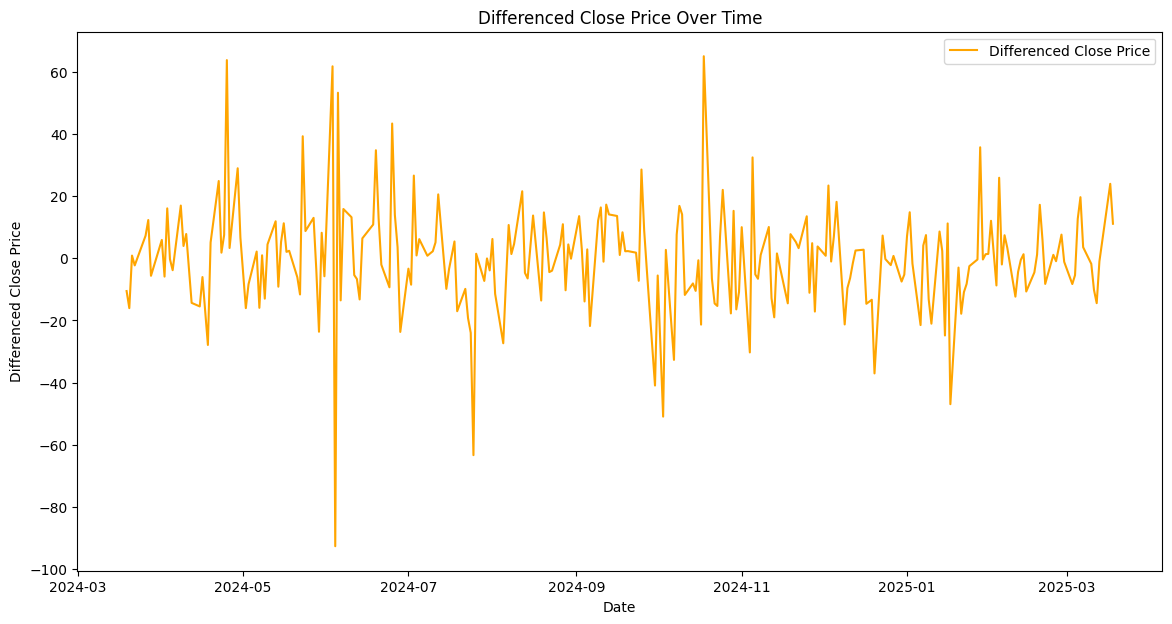

In [240]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(dataframe.index, dataframe['Close_Diff'], label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

Arima model identification- finding the p, d, and q terms that go into our ARIMA model.

*p (AutoRegressive Order - AR term)*
*   It determines how many past values influence the present.
*   Identified using the Partial Autocorrelation Function (PACF) plot.
* where PACF cuts off is p

*d (Differencing Order- I term)*
* The number of times differencing is applied to make the series stationary.
* If a single differencing makes the series stationary, then d = 1.

*q (Moving Average Order - MA term)*
* The number of past forecast errors included in the model.
* Identified using the Autocorrelation Function (ACF) plot.
* The number of lags where ACF cuts off is q



In [241]:
print(len(dataframe['Close_Diff'].dropna()))

248


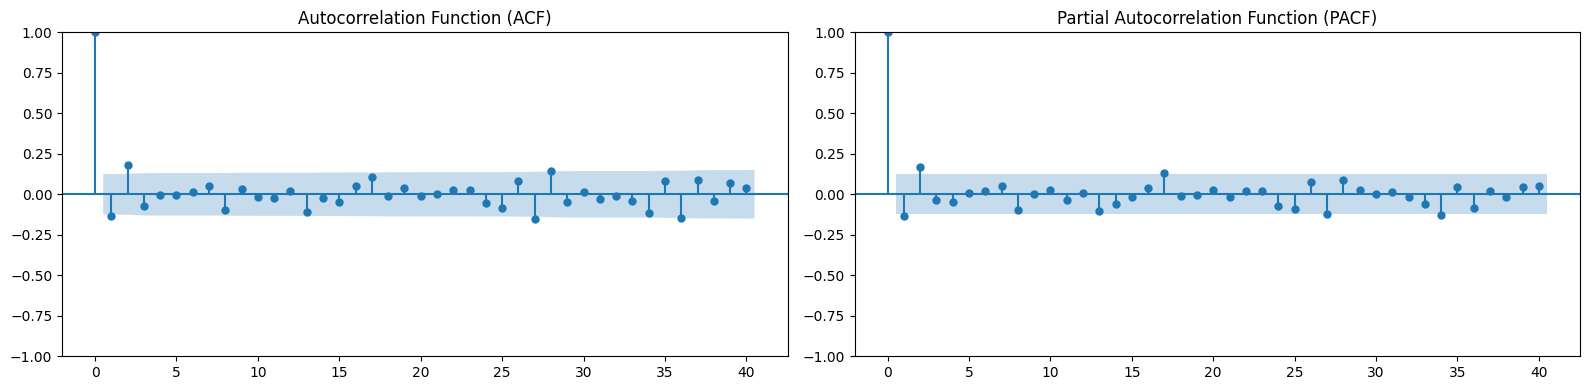

In [242]:
#using acf and pacf to find the trends

# Automatically select lags based on data length
num_lags = min(len(dataframe['Close_Diff'].dropna()) // 4, 40)  # Use up to 40 lags, or 1/4th of data length

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(dataframe['Close_Diff'].dropna(), lags=num_lags, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(dataframe['Close_Diff'].dropna(), lags=num_lags, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

p (AR order) ≈ 1 (since PACF cuts off after lag 1)

q (MA order) ≈ 1 (since ACF cuts off after lag 1)

d (Differencing order) is 1 as we perfomed the difference function once

Again - the p, d, and q values in ARIMA represent the model's order (lags for autoregression, differencing, and moving average terms), but they are not the actual parameters being estimated.

In [243]:
#splitting train test and running
train_size = int(len(dataframe) * 0.8)
train, test = dataframe.iloc[:train_size], dataframe.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train["close"], order=(1,1,1))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


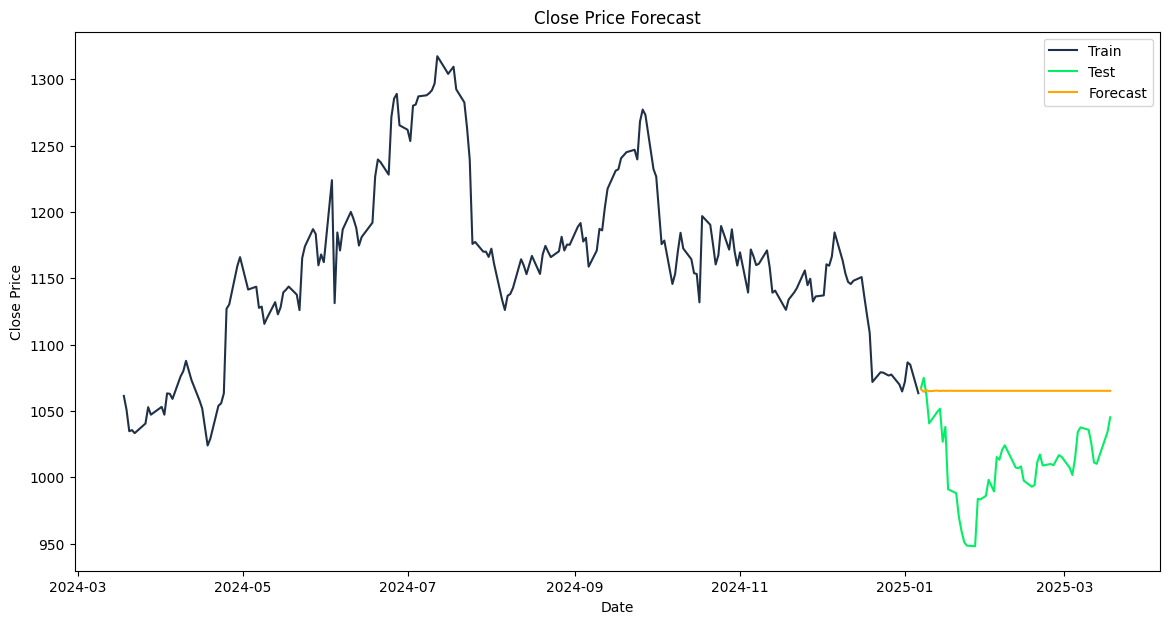

In [244]:
#visualising our time series - forcasting
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["close"], label='Train', color='#203147')
plt.plot(test.index, test["close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [245]:
#evaluating model stats - AIC and BIC - Lower values mean the model fits better
#print(f"AIC: {model_fit.aic}")
#print(f"BIC: {model_fit.bic}")

#output
#AIC: 844.1309512687794
#BIC: 851.9163108191832

In [246]:
#RSME - A lower RMSE indicates a better ARIMA model
forecast = forecast[:len(test)]
test_close = test["close"][:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 61.4877


Shows a difference of rs. 61.4877 Which is well fitted - Based on 1 year


In [247]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#import numpy as np

mae = mean_absolute_error(test_close, forecast)
mse = mean_squared_error(test_close, forecast)
mape = np.mean(np.abs((test_close - forecast) / test_close)) * 100
r2 = r2_score(test_close, forecast)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-Squared (R²): {r2:.2f}")


Mean Absolute Error (MAE): 55.05380384999058
Mean Squared Error (MSE): 3780.7372490190296
Mean Absolute Percentage Error (MAPE): nan%
R-Squared (R²): -3.71


<ipython-input-247-04e99079e6ae>:6: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test_close - forecast) / test_close)) * 100
